In [1]:
import numpy as np
import matplotlib.cm as cm
from matplotlib import ticker
import math
import scipy
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import dask
from sklearn.neighbors import KDTree
import netCDF4
from metpy import calc
from metpy.units import units

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from IPython.display import HTML
from matplotlib import animation
from matplotlib.gridspec import GridSpec

In [2]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw
plt.rc('hatch', color='k', linewidth=1.5)

In [3]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc")
levs = np.array(others.variables['lev'])
lons = np.array(others.variables['lon'])
new = np.flip(levs)
crms = np.arange(1,129,1)
Xs, Zs = np.meshgrid(crms, new)

In [4]:
def angle_generator(angle):
    R = np.zeros(shape=(2,2))
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R[0,0] = c
    R[0,1] = -s
    R[1,0] = s
    R[1,1] = c
    return R

In [5]:
def array_rotator(array, angle):
    rotated_array = np.empty(array.shape)
    R = angle_generator(angle)
    for i in range(len(array)):
        rotated_array[i, :] =  np.dot(R, array[i,:])  
    
    return rotated_array 

In [6]:
z_test_tsne_track_31_sam = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/latent_space/UM/Big_SAM_Interp_For_UM_2D_PCA_Latent_Space__4503.npy", mmap_mode="r")
z_test_tsne_track_31_sam_origin = np.load('/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/latent_space/UM/Big_SPCAM_Interp_For_UM_2D_PCA_Latent_Space__4503.npy', mmap_mode="r")
z_test_tsne_track_31_IFS = np.load('/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/latent_space/UM/Big_IFS_Interp_For_UM_2D_PCA_Latent_Space__4503.npy', mmap_mode="r")
z_test_tsne_track_31_NICAM = np.load('/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/latent_space/UM/Big_NICAM_Interp_For_UM_2D_PCA_Latent_Space__4503.npy', mmap_mode="r")
z_test_tsne_track_31_SHIELD = np.load('/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/latent_space/UM/Big_SHIELD_Interp_For_UM_2D_PCA_Latent_Space__4503.npy')
z_test_tsne_track_31_ICON = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/latent_space/UM/Big_ICON_Interp_For_UM_2D_PCA_Latent_Space__4503.npy", mmap_mode="r")
z_test_tsne_track_31_ARPEGE = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/latent_space/UM/Big_ARPEGE_Interp_For_UM_2D_PCA_Latent_Space__4503.npy", mmap_mode="r")
z_test_tsne_track_31_GEM = np.load('/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/latent_space/UM/Big_GEM_Interp_For_UM_2D_PCA_Latent_Space__4503.npy')
z_test_tsne_track_31_UM = np.load('/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/latent_space/UM/Big_UM_2D_PCA_Latent_Space__4503.npy')

In [7]:
max_corr = 117
z_test_tsne_track_31_sam  = array_rotator(z_test_tsne_track_31_sam , max_corr)
z_test_tsne_track_31_sam_origin  = array_rotator(z_test_tsne_track_31_sam_origin , max_corr)
z_test_tsne_track_31_IFS  = array_rotator(z_test_tsne_track_31_IFS , max_corr)
z_test_tsne_track_31_NICAM  = array_rotator(z_test_tsne_track_31_NICAM , max_corr)
z_test_tsne_track_31_SHIELD  = array_rotator(z_test_tsne_track_31_SHIELD , max_corr)
z_test_tsne_track_31_ICON  = array_rotator(z_test_tsne_track_31_ICON , max_corr)
z_test_tsne_track_31_ARPEGE  = array_rotator(z_test_tsne_track_31_ARPEGE , max_corr)
z_test_tsne_track_31_GEM  = array_rotator(z_test_tsne_track_31_GEM , max_corr)
z_test_tsne_track_31_UM  = array_rotator(z_test_tsne_track_31_UM , max_corr)

# Cluster (Method 2 -- only do reassignments)

In [8]:
# scaled, saved centers
labels_3_original = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Scaled_Mandt_Method_Small_SPCAM_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_SAM = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Scaled_Mandt_Method_Small_SAM_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_UM = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Small_UM_Labels_4503_Z_3.npy").astype(int)
labels_3_SHIELD = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Scaled_Mandt_Method_Small_SHIELD_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_ICON = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Scaled_Mandt_Method_Small_ICON_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_ARPEGE = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Scaled_Mandt_Method_Small_ARPEGE_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_NICAM = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Scaled_Mandt_Method_Small_NICAM_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_GEM = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Scaled_Mandt_Method_Small_GEM_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_IFS = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Scaled_Mandt_Method_Small_IFS_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


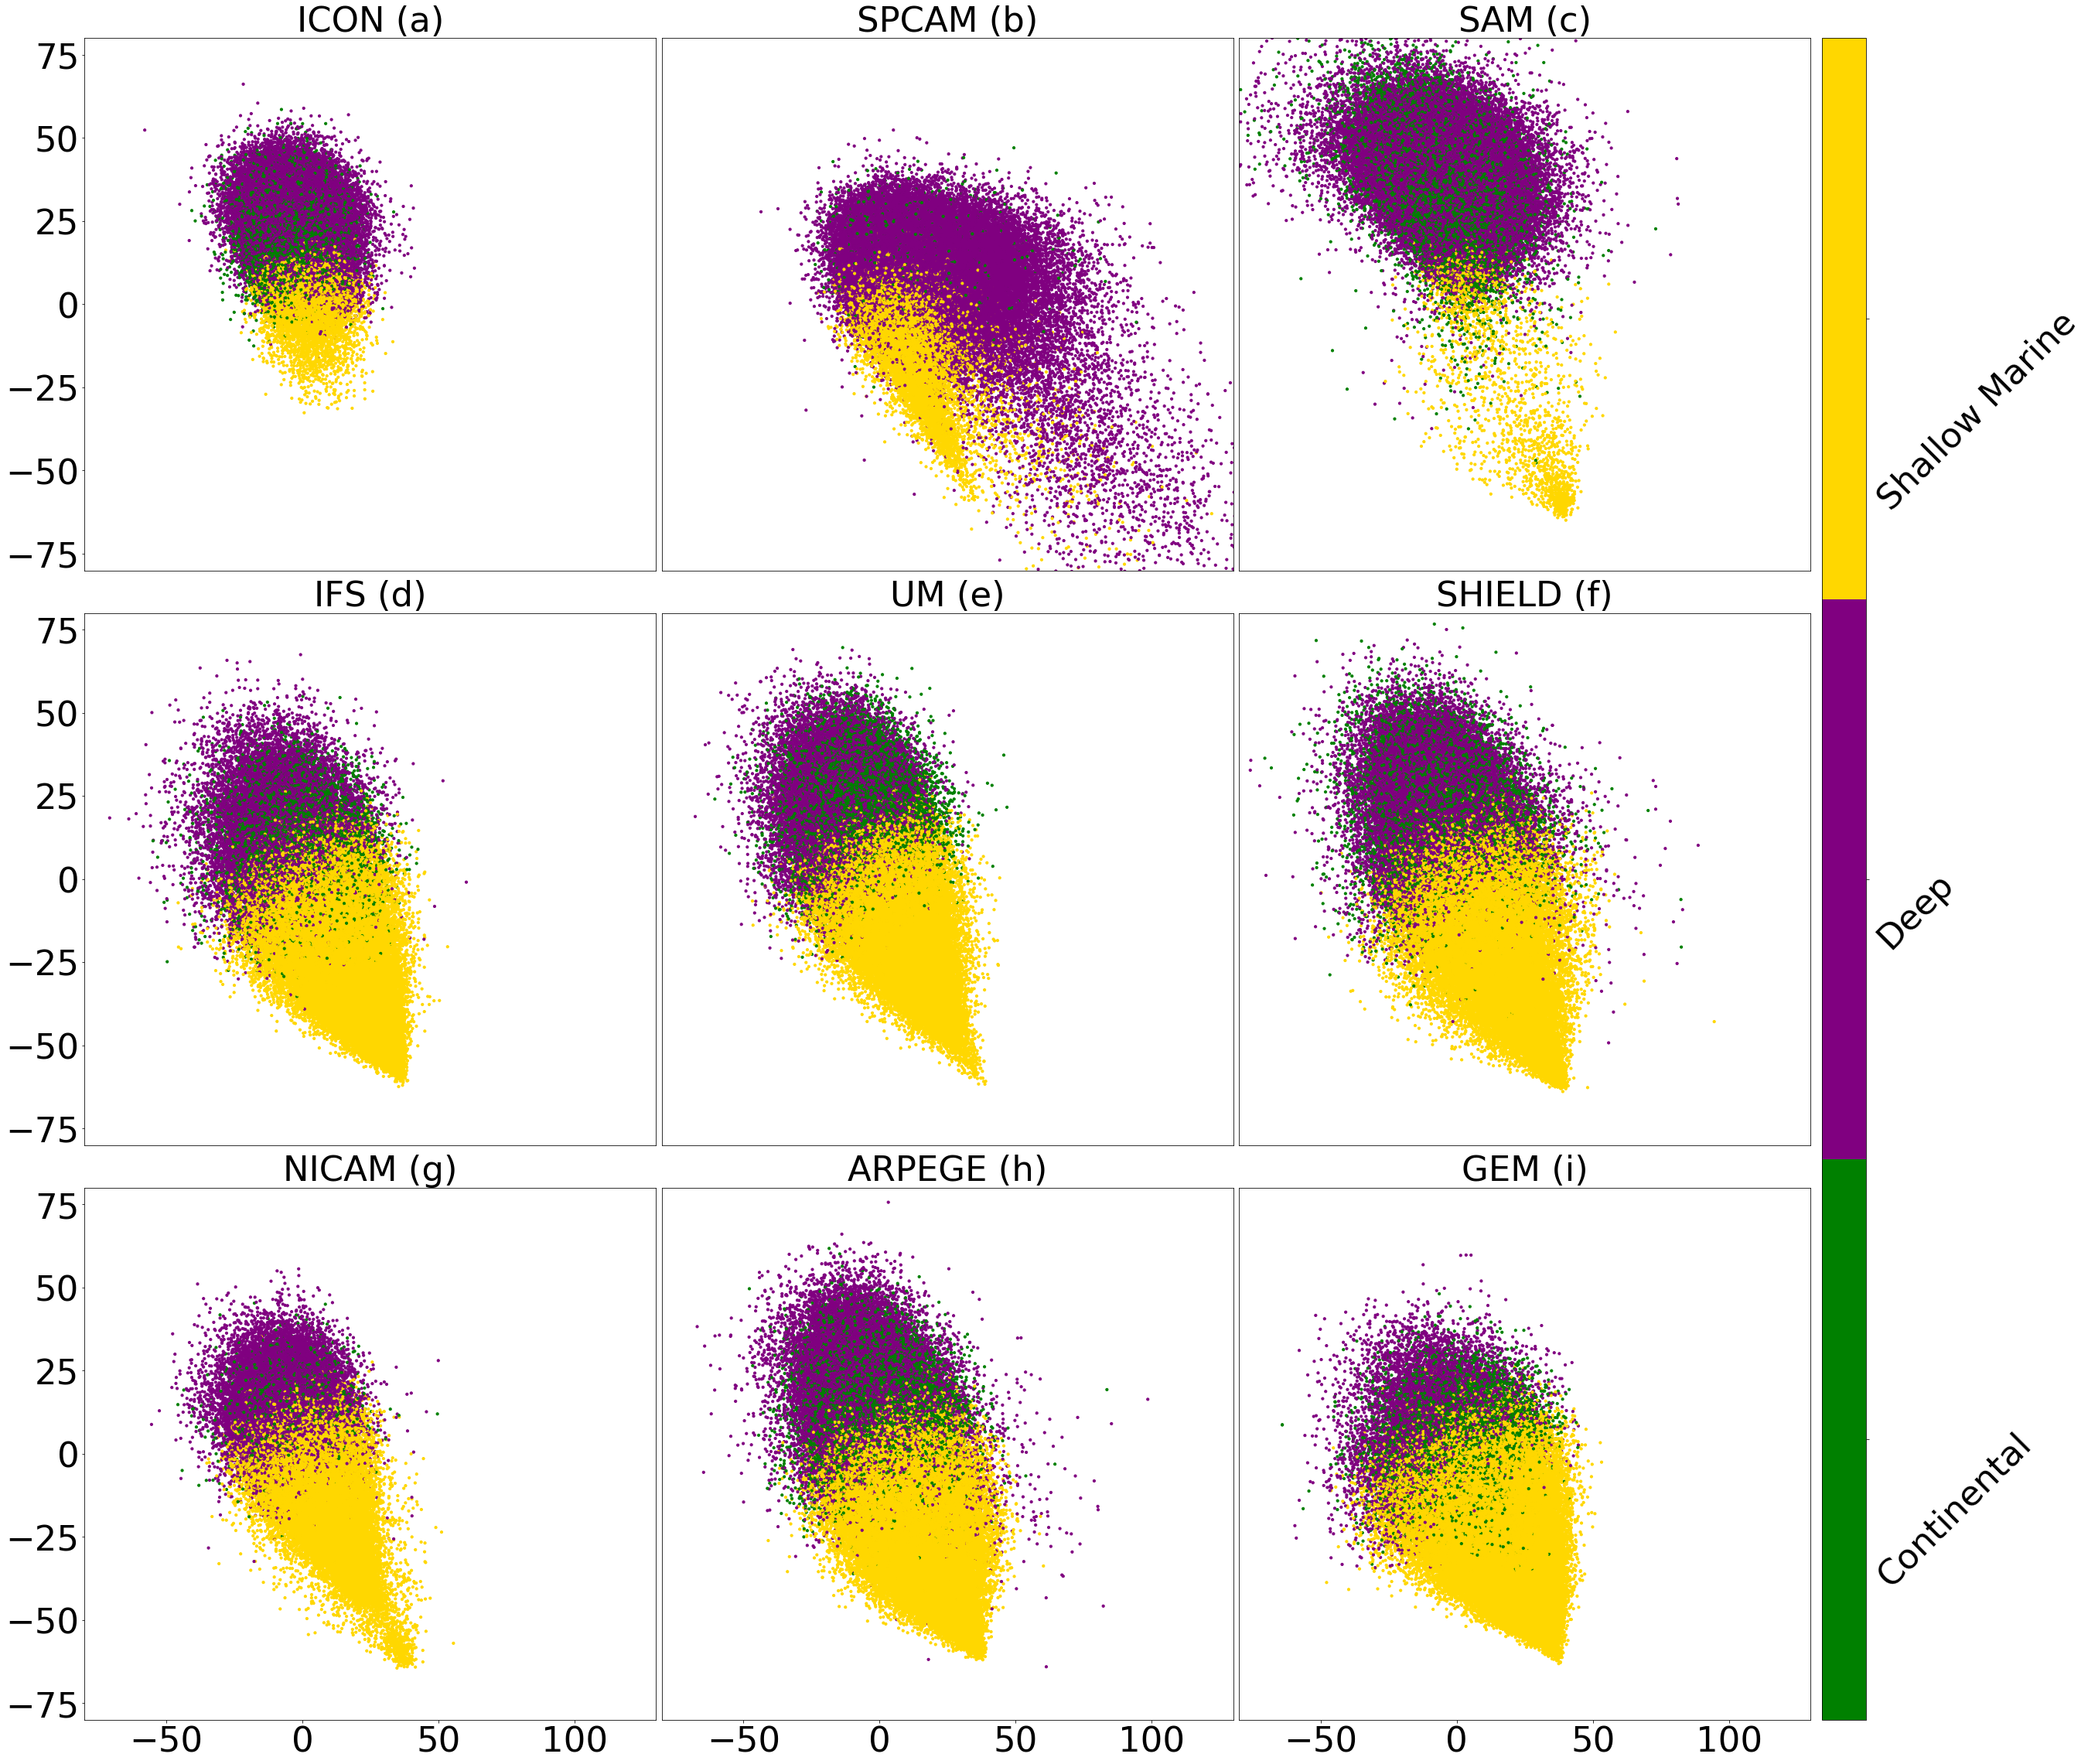

In [9]:
fig, ax = plt.subplots(3,3,figsize=(40,40))
gs=GridSpec(3,3)
cmap = matplotlib.colors.ListedColormap(["green","purple","gold"])

ax1=fig.add_subplot(gs[0,0])

cp = ax1.scatter(x=z_test_tsne_track_31_ICON[:, 0],  y=z_test_tsne_track_31_ICON[:, 1], c=labels_3_ICON, cmap=cmap, s=10.0)
ax1.set_title("ICON (a)", fontsize = fz*2, y = 1)

ax1.set_xlim(-80,130)
ax1.set_ylim(-80,80)
ax1.set_xticks([])
ax1.tick_params(axis='y', which='major', labelsize=fz*2)

ax2=fig.add_subplot(gs[0,1])

cp = ax2.scatter(x=z_test_tsne_track_31_sam_origin[:, 0], y=z_test_tsne_track_31_sam_origin[:, 1], c=labels_3_original, cmap=cmap, s=10.0)
ax2.set_title("SPCAM (b)", fontsize = fz*2, y = 1)

ax2.set_xlim(-80,130)
ax2.set_ylim(-80,80)
ax2.set_xticks([])
ax2.set_yticks([])

ax3=fig.add_subplot(gs[0,2])

cp = ax3.scatter(x=z_test_tsne_track_31_sam[:, 0], y=z_test_tsne_track_31_sam[:, 1], c=labels_3_SAM, cmap=cmap, s=10.0)
ax3.set_title("SAM (c)", fontsize = fz*2, y = 1)

ax3.set_xlim(-80,130)
ax3.set_ylim(-80,80)
ax3.set_xticks([])
ax3.set_yticks([])

ax4=fig.add_subplot(gs[1,0])

cp = ax4.scatter(x=z_test_tsne_track_31_IFS[:, 0], y=z_test_tsne_track_31_IFS[:, 1], c=labels_3_IFS, cmap=cmap, s=10.0)
ax4.set_title("IFS (d)", fontsize = fz*2, y = 1)

ax4.set_xlim(-80,130)
ax4.set_ylim(-80,80)
ax4.set_xticks([])
ax4.tick_params(axis='y', which='major', labelsize=fz*2)

ax5=fig.add_subplot(gs[1,1])

cp = ax5.scatter(x=z_test_tsne_track_31_UM[:, 0], y=z_test_tsne_track_31_UM[:, 1], c=labels_3_UM, cmap=cmap, s=10.0)
ax5.set_title("UM (e)", fontsize = fz*2, y = 1)

ax5.set_xlim(-80,130)
ax5.set_ylim(-80,80)
ax5.set_xticks([])
ax5.set_yticks([])

ax6=fig.add_subplot(gs[1,2])

cp = ax6.scatter(x=z_test_tsne_track_31_SHIELD[:, 0], y=z_test_tsne_track_31_SHIELD[:, 1], c=labels_3_SHIELD, cmap=cmap, s=10.0)
ax6.set_title("SHIELD (f)", fontsize = fz*2, y = 1)

ax6.set_xlim(-80,130)
ax6.set_ylim(-80,80)
ax6.set_xticks([])
ax6.set_yticks([])

ax7=fig.add_subplot(gs[2,0])

cp = ax7.scatter(x=z_test_tsne_track_31_NICAM[:, 0], y=z_test_tsne_track_31_NICAM[:, 1], c=labels_3_NICAM, cmap=cmap, s=10.0)
ax7.set_title("NICAM (g)", fontsize = fz*2, y = 1)

ax7.set_xlim(-80,130)
ax7.set_ylim(-80,80)
ax7.tick_params(axis='both', which='major', labelsize=fz*2)

ax8=fig.add_subplot(gs[2,1])

cp = ax8.scatter(x=z_test_tsne_track_31_ARPEGE[:, 0], y=z_test_tsne_track_31_ARPEGE[:, 1], c=labels_3_ARPEGE, cmap=cmap, s=10.0)
ax8.set_title("ARPEGE (h)", fontsize = fz*2, y = 1)

ax8.set_xlim(-80,130)
ax8.set_ylim(-80,80)
ax8.set_yticks([])
ax8.tick_params(axis='x', which='major', labelsize=fz*2)

ax9=fig.add_subplot(gs[2,2])

cp = ax9.scatter(x=z_test_tsne_track_31_GEM[:, 0], y=z_test_tsne_track_31_GEM[:, 1], c=labels_3_GEM, cmap=cmap, s=10.0)
ax9.set_title("GEM (i)", fontsize = fz*2, y = 1)

ax9.set_xlim(-80,130)
ax9.set_ylim(-80,80)
ax9.set_yticks([])
ax9.tick_params(axis='x', which='major', labelsize=fz*2)

cbar_ax = fig.add_axes([0.905, 0.125, 0.02, 0.755])
cbar = fig.colorbar(cp, cax=cbar_ax)

n_clusters=3
tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
cbar.set_ticks(tick_locs)
cbar.ax.set_yticklabels(["Continental","Deep","Shallow Marine"], fontsize=fz*2, rotation=45)

fig.delaxes(ax[0,0])
fig.delaxes(ax[0,1])
fig.delaxes(ax[0,2])
fig.delaxes(ax[1,0])
fig.delaxes(ax[1,1])
fig.delaxes(ax[1,2])
fig.delaxes(ax[2,0])
fig.delaxes(ax[2,1])
fig.delaxes(ax[2,2])

plt.subplots_adjust(wspace=0.01, hspace=0.08)
plt.savefig("../Figures/Figure_2.png", bbox_inches='tight', pad_inches = 0.1)


In [39]:
#ICON Trained VAE
elbo_um_1 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/Anomalies/Matrix/ICON/UM_Interp_For_ICON_ELBO_4400.npy")/(30.*128.*1024)

#IFS Trained VAE
elbo_um_2 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/Anomalies/Matrix/IFS/UM_Interp_For_IFS_ELBO_4301.npy")/(30.*128.*1024)

#SPCAM Trained VAE
elbo_um_3 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/Anomalies/Matrix/SPCAM/UM_Interp_For_SPCAM_ELBO_3100.npy")/(30.*128.*1024)

# SHIELD Trained VAE
elbo_um_4 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/Anomalies/Matrix/SHIELD/UM_Interp_For_SHIELD_ELBO_4601.npy")/(30.*128.*1024)

# SAM Trained VAE
elbo_um_5 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/Anomalies/Matrix/SAM/UM_Interp_For_SAM_ELBO_4100.npy")/(30.*128.*1024)

# ARPEGE Trained VAE
elbo_um_6 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/Anomalies/Matrix/ARPEGE/UM_Interp_For_ARPEGE_ELBO_4802.npy")/(30.*128.*1024)

# UM Trained VAE
elbo_icon_7 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/Anomalies/Matrix/UM/ICON_Interp_For_UM_ELBO_4503.npy")/(30.*128.*1024)
elbo_ifs_7 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/Anomalies/Matrix/UM/IFS_Interp_For_UM_ELBO_4503.npy")/(30.*128.*1024)
elbo_spcam_7 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/Anomalies/Matrix/UM/SPCAM_Interp_For_UM_ELBO_4503.npy")/(30.*128.*1024)
elbo_shield_7 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/Anomalies/Matrix/UM/SHIELD_Interp_For_UM_ELBO_4503.npy")/(30.*128.*1024)
elbo_sam_7 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/Anomalies/Matrix/UM/SAM_Interp_For_UM_ELBO_4503.npy")/(30.*128.*1024)
elbo_arpege_7 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/Anomalies/Matrix/UM/ARPEGE_Interp_For_UM_ELBO_4503.npy")/(30.*128.*1024)
elbo_um_7 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/Anomalies/Matrix/UM/UM_ELBO_4503.npy")/(30.*128.*1024)
elbo_nicam_7 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/Anomalies/Matrix/UM/NICAM_Interp_For_UM_ELBO_4503.npy")/(30.*128.*1024)
elbo_gem_7 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/Anomalies/Matrix/UM/GEM_Interp_For_UM_ELBO_4503.npy")/(30.*128.*1024)

# NICAM Trained VAE
elbo_um_8 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/Anomalies/Matrix/NICAM/UM_Interp_For_NICAM_ELBO_4213.npy")/(30.*128.*1024)

# GEM Trained VAE
elbo_um_9 = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/Anomalies/Matrix/GEM/UM_Interp_For_GEM_ELBO_4703.npy")/(30.*128.*1024)


findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


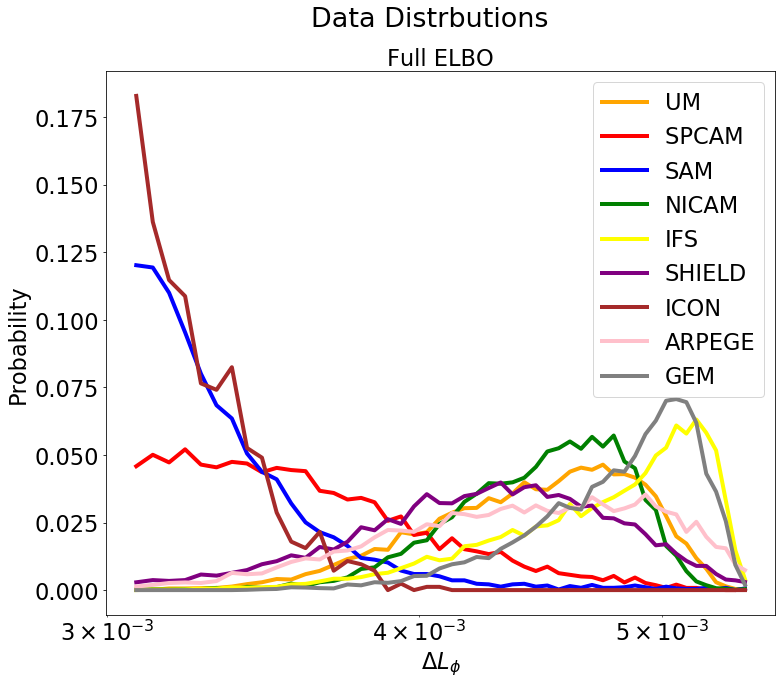

In [40]:
fig, ax = plt.subplots(figsize=(12,10))

shared_bins = np.histogram_bin_edges(elbo_um_7, bins=50)
um_freq, um_edges = np.histogram(elbo_um_7, bins = shared_bins, density=True)
icon_freq, icon_edges = np.histogram(elbo_icon_7, bins = shared_bins, density=True)
ifs_freq, ifs_edges = np.histogram(elbo_ifs_7, bins = shared_bins, density=True)
spcam_freq, spcam_edges = np.histogram(elbo_spcam_7, bins = shared_bins, density=True)
shield_freq, shield_edges = np.histogram(elbo_shield_7, bins = shared_bins, density=True)
sam_freq, sam_edges = np.histogram(elbo_sam_7, bins = shared_bins, density=True)
arpege_freq, arpege_edges = np.histogram(elbo_arpege_7, bins = shared_bins, density=True)
nicam_freq, nicam_edges = np.histogram(elbo_nicam_7, bins = shared_bins, density=True)
gem_freq, gem_edges = np.histogram(elbo_gem_7, bins = shared_bins, density=True)


ax.set_xscale("log")
ax.set_xscale("log")

ax.plot(um_edges[:-1], um_freq/np.sum(um_freq),  label = "UM", color = 'orange')
ax.plot(spcam_edges[:-1], spcam_freq/np.sum(spcam_freq), label = "SPCAM ", color = 'red')
ax.plot(sam_edges[:-1], sam_freq/np.sum(sam_freq), label = "SAM", color = 'blue')
ax.plot(nicam_edges[:-1], nicam_freq/np.sum(nicam_freq), label = "NICAM", color = 'green')
ax.plot(ifs_edges[:-1], ifs_freq/np.sum(ifs_freq), label = "IFS", color = 'yellow')
ax.plot(shield_edges[:-1], shield_freq/np.sum(shield_freq), label = "SHIELD", color = 'purple')
ax.plot(icon_edges[:-1], icon_freq/np.sum(icon_freq), label = "ICON", color = 'brown')
ax.plot(arpege_edges[:-1], arpege_freq/np.sum(arpege_freq), label = "ARPEGE", color = 'pink')
ax.plot(gem_edges[:-1], gem_freq/np.sum(gem_freq), label = "GEM", color = 'grey')

ax.legend()
ax.set_xlabel(r"$\Delta {\mathit{L}}_\phi$", fontsize = fz)
ax.set_ylabel('Probability', fontsize = fz)
ax.set_title('Full ELBO PDFs', fontsize = fz)

plt.subplots_adjust(wspace=0.01, hspace=0.10)

#plt.savefig("Figures/Figure_Extra_Panels.png")
#plt.savefig("Figures/Figure_Extra_Panels.pdf")

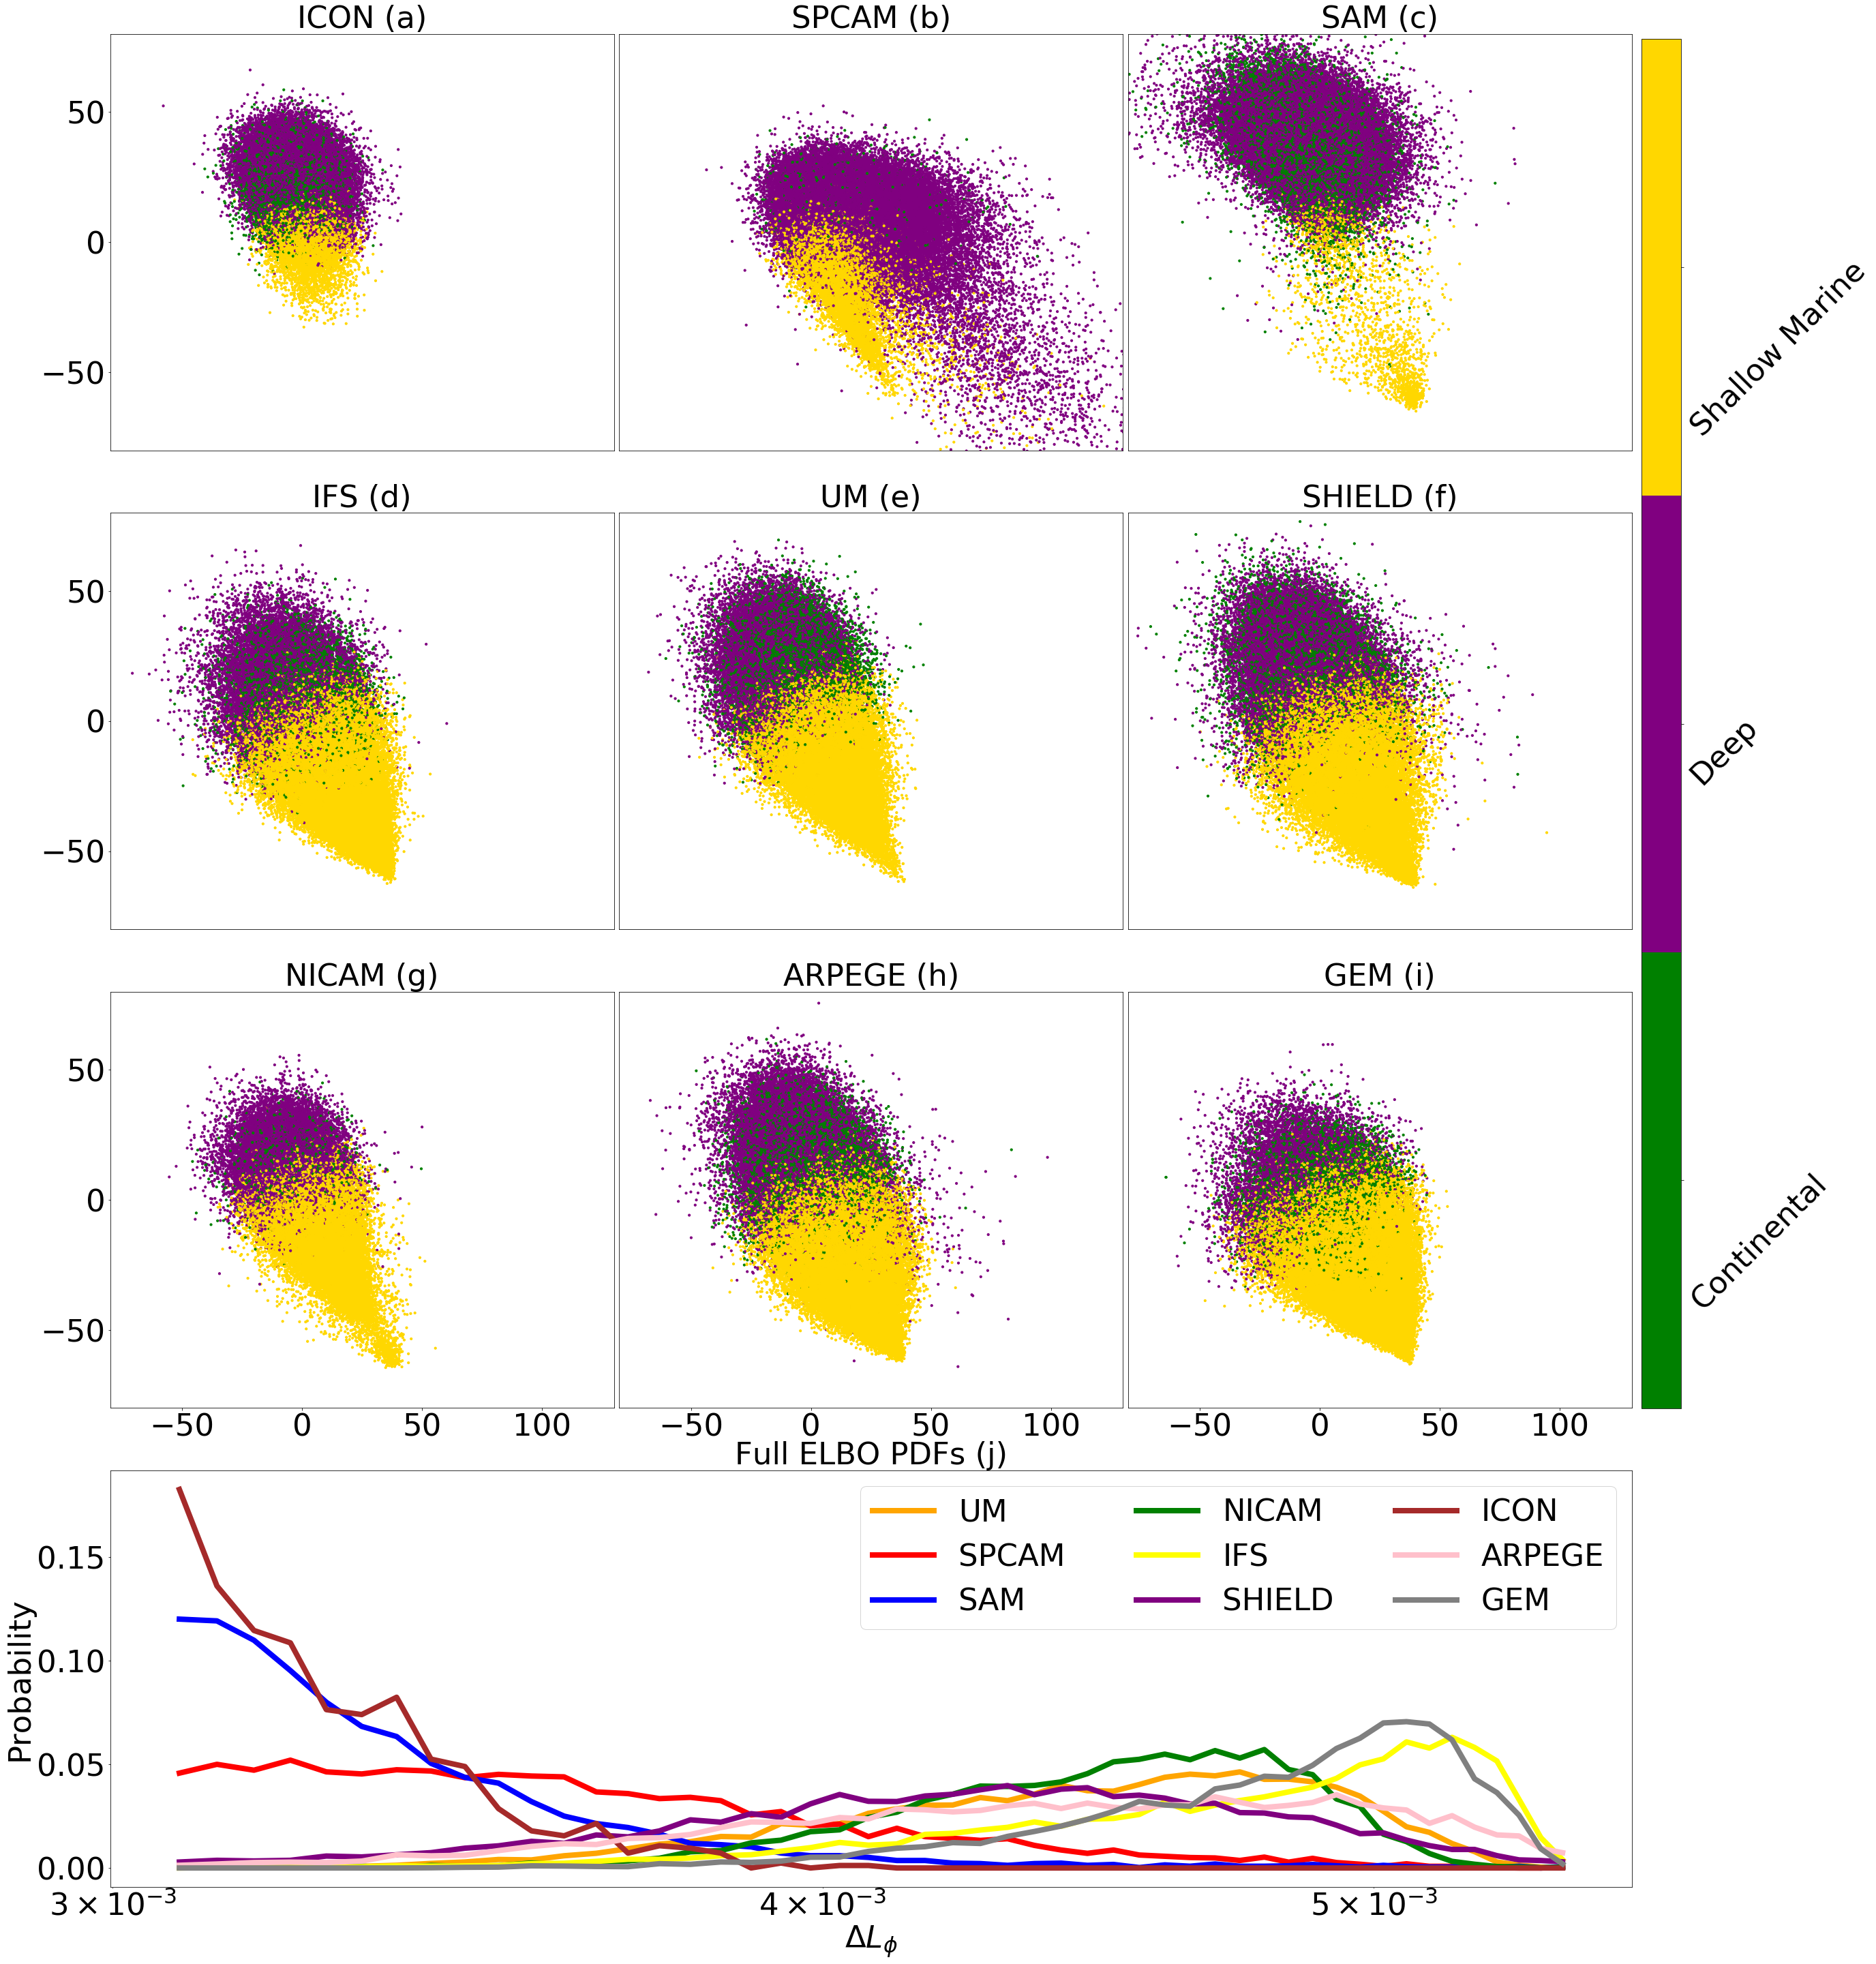

In [59]:
fig, ax = plt.subplots(4,3,figsize=(40,50))
gs=GridSpec(4,3)
cmap = matplotlib.colors.ListedColormap(["green","purple","gold"])

ax1=fig.add_subplot(gs[0,0])

cp = ax1.scatter(x=z_test_tsne_track_31_ICON[:, 0],  y=z_test_tsne_track_31_ICON[:, 1], c=labels_3_ICON, cmap=cmap, s=10.0)
ax1.set_title("ICON (a)", fontsize = fz*2, y = 1)

ax1.set_xlim(-80,130)
ax1.set_ylim(-80,80)
ax1.set_xticks([])
ax1.tick_params(axis='y', which='major', labelsize=fz*2)

ax2=fig.add_subplot(gs[0,1])

cp = ax2.scatter(x=z_test_tsne_track_31_sam_origin[:, 0], y=z_test_tsne_track_31_sam_origin[:, 1], c=labels_3_original, cmap=cmap, s=10.0)
ax2.set_title("SPCAM (b)", fontsize = fz*2, y = 1)

ax2.set_xlim(-80,130)
ax2.set_ylim(-80,80)
ax2.set_xticks([])
ax2.set_yticks([])

ax3=fig.add_subplot(gs[0,2])

cp = ax3.scatter(x=z_test_tsne_track_31_sam[:, 0], y=z_test_tsne_track_31_sam[:, 1], c=labels_3_SAM, cmap=cmap, s=10.0)
ax3.set_title("SAM (c)", fontsize = fz*2, y = 1)

ax3.set_xlim(-80,130)
ax3.set_ylim(-80,80)
ax3.set_xticks([])
ax3.set_yticks([])

ax4=fig.add_subplot(gs[1,0])

cp = ax4.scatter(x=z_test_tsne_track_31_IFS[:, 0], y=z_test_tsne_track_31_IFS[:, 1], c=labels_3_IFS, cmap=cmap, s=10.0)
ax4.set_title("IFS (d)", fontsize = fz*2, y = 1)

ax4.set_xlim(-80,130)
ax4.set_ylim(-80,80)
ax4.set_xticks([])
ax4.tick_params(axis='y', which='major', labelsize=fz*2)

ax5=fig.add_subplot(gs[1,1])

cp = ax5.scatter(x=z_test_tsne_track_31_UM[:, 0], y=z_test_tsne_track_31_UM[:, 1], c=labels_3_UM, cmap=cmap, s=10.0)
ax5.set_title("UM (e)", fontsize = fz*2, y = 1)

ax5.set_xlim(-80,130)
ax5.set_ylim(-80,80)
ax5.set_xticks([])
ax5.set_yticks([])

ax6=fig.add_subplot(gs[1,2])

cp = ax6.scatter(x=z_test_tsne_track_31_SHIELD[:, 0], y=z_test_tsne_track_31_SHIELD[:, 1], c=labels_3_SHIELD, cmap=cmap, s=10.0)
ax6.set_title("SHIELD (f)", fontsize = fz*2, y = 1)

ax6.set_xlim(-80,130)
ax6.set_ylim(-80,80)
ax6.set_xticks([])
ax6.set_yticks([])

ax7=fig.add_subplot(gs[2,0])

cp = ax7.scatter(x=z_test_tsne_track_31_NICAM[:, 0], y=z_test_tsne_track_31_NICAM[:, 1], c=labels_3_NICAM, cmap=cmap, s=10.0)
ax7.set_title("NICAM (g)", fontsize = fz*2, y = 1)

ax7.set_xlim(-80,130)
ax7.set_ylim(-80,80)
ax7.tick_params(axis='both', which='major', labelsize=fz*2)

ax8=fig.add_subplot(gs[2,1])

cp = ax8.scatter(x=z_test_tsne_track_31_ARPEGE[:, 0], y=z_test_tsne_track_31_ARPEGE[:, 1], c=labels_3_ARPEGE, cmap=cmap, s=10.0)
ax8.set_title("ARPEGE (h)", fontsize = fz*2, y = 1)

ax8.set_xlim(-80,130)
ax8.set_ylim(-80,80)
ax8.set_yticks([])
ax8.tick_params(axis='x', which='major', labelsize=fz*2)

ax9=fig.add_subplot(gs[2,2])

cp = ax9.scatter(x=z_test_tsne_track_31_GEM[:, 0], y=z_test_tsne_track_31_GEM[:, 1], c=labels_3_GEM, cmap=cmap, s=10.0)
ax9.set_title("GEM (i)", fontsize = fz*2, y = 1)

ax9.set_xlim(-80,130)
ax9.set_ylim(-80,80)
ax9.set_yticks([])
ax9.tick_params(axis='x', which='major', labelsize=fz*2)

cbar_ax = fig.add_axes([0.905, 0.32, 0.02, 0.558])
cbar = fig.colorbar(cp, cax=cbar_ax)

n_clusters=3
tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
cbar.set_ticks(tick_locs)
cbar.ax.set_yticklabels(["Continental","Deep","Shallow Marine"], fontsize=fz*2, rotation=45)

ax10=fig.add_subplot(gs[3,:])

shared_bins = np.histogram_bin_edges(elbo_um_7, bins=50)
um_freq, um_edges = np.histogram(elbo_um_7, bins = shared_bins, density=True)
icon_freq, icon_edges = np.histogram(elbo_icon_7, bins = shared_bins, density=True)
ifs_freq, ifs_edges = np.histogram(elbo_ifs_7, bins = shared_bins, density=True)
spcam_freq, spcam_edges = np.histogram(elbo_spcam_7, bins = shared_bins, density=True)
shield_freq, shield_edges = np.histogram(elbo_shield_7, bins = shared_bins, density=True)
sam_freq, sam_edges = np.histogram(elbo_sam_7, bins = shared_bins, density=True)
arpege_freq, arpege_edges = np.histogram(elbo_arpege_7, bins = shared_bins, density=True)
nicam_freq, nicam_edges = np.histogram(elbo_nicam_7, bins = shared_bins, density=True)
gem_freq, gem_edges = np.histogram(elbo_gem_7, bins = shared_bins, density=True)

ax10.plot(um_edges[:-1], um_freq/np.sum(um_freq),  label = "UM", color = 'orange', linewidth=8)
ax10.plot(spcam_edges[:-1], spcam_freq/np.sum(spcam_freq), label = "SPCAM ", color = 'red', linewidth=8)
ax10.plot(sam_edges[:-1], sam_freq/np.sum(sam_freq), label = "SAM", color = 'blue', linewidth=8)
ax10.plot(nicam_edges[:-1], nicam_freq/np.sum(nicam_freq), label = "NICAM", color = 'green', linewidth=8)
ax10.plot(ifs_edges[:-1], ifs_freq/np.sum(ifs_freq), label = "IFS", color = 'yellow', linewidth=8)
ax10.plot(shield_edges[:-1], shield_freq/np.sum(shield_freq), label = "SHIELD", color = 'purple', linewidth=8)
ax10.plot(icon_edges[:-1], icon_freq/np.sum(icon_freq), label = "ICON", color = 'brown', linewidth=8)
ax10.plot(arpege_edges[:-1], arpege_freq/np.sum(arpege_freq), label = "ARPEGE", color = 'pink', linewidth=8)
ax10.plot(gem_edges[:-1], gem_freq/np.sum(gem_freq), label = "GEM", color = 'grey', linewidth=8)

ax10.legend(fontsize=fz*2, ncol=3)
ax10.set_xlabel(r"$\Delta {\mathit{L}}_\phi$", fontsize = 2*fz)
ax10.set_ylabel('Probability', fontsize = 2*fz)
ax10.set_title('Full ELBO PDFs (j)', fontsize = 2*fz)

ax10.set_xscale("log")
ax10.tick_params(axis='both', which='both', labelsize=fz*2)
#ax10.tick_params(axis='y', which='major', labelsize=fz*2)


fig.delaxes(ax[0,0])
fig.delaxes(ax[0,1])
fig.delaxes(ax[0,2])
fig.delaxes(ax[1,0])
fig.delaxes(ax[1,1])
fig.delaxes(ax[1,2])
fig.delaxes(ax[2,0])
fig.delaxes(ax[2,1])
fig.delaxes(ax[2,2])
fig.delaxes(ax[3,0])
fig.delaxes(ax[3,1])
fig.delaxes(ax[3,2])

plt.subplots_adjust(wspace=0.01, hspace=0.15)
plt.savefig("../Figures/Figure_2.png", bbox_inches='tight', pad_inches = 0.1)